Some papers and blog posts on learn to rank:

https://medium.com/@nikhilbd/intuitive-explanation-of-learning-to-rank-and-ranknet-lambdarank-and-lambdamart-fe1e17fac418

https://www.aclweb.org/anthology/P09-5005.pdf

https://www.microsoft.com/en-us/research/publication/from-ranknet-to-lambdarank-to-lambdamart-an-overview/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F132652%2Fmsr-tr-2010-82.pdf

https://developer.nvidia.com/blog/learning-to-rank-with-xgboost-and-gpu/

http://times.cs.uiuc.edu/course/598f14/l2r.pdf

https://www.researchgate.net/profile/Ruofei_Zhang/publication/221023260_A_stochastic_learning-to-rank_algorithm_and_its_application_to_contextual_advertising/links/53f10c210cf2711e0c432644/A-stochastic-learning-to-rank-algorithm-and-its-application-to-contextual-advertising.pdf


In [1]:
import sys
import time
import math
from itertools import product
from time import strftime
from datetime import datetime, timedelta
from calendar import monthrange

import numpy as np
import pandas as pd
import pandas_datareader.data as datareader

import sklearn
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold, GridSearchCV
from sklearn.datasets import load_svmlight_file

import ray
from ray import tune
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.optuna import OptunaSearch

import xgboost
from xgboost import XGBRegressor, XGBRanker

import lightgbm as lgb
from lightgbm import LGBMRanker 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

%matplotlib inline

# np.random.randint(10000) # 2823
RANDOMSTATE=2823
LAG=0

print("%-20s %10s" % ("numpy", np.__version__))
print("%-20s %10s" % ("pandas", pd.__version__))
print("%-20s %10s" % ("sklearn", sklearn.__version__))
print("%-20s %10s" % ("matplotlib", mpl.__version__))
print("%-20s %10s" % ("seaborn", sns.__version__))
print("%-20s %10s" % ("XGBoost", xgboost.__version__))
print("%-20s %10s" % ("LGBM", lgb.__version__))
print("%-20s %10s" % ("ray", ray.__version__))


numpy                    1.19.4
pandas                    1.2.0
sklearn                  0.24.0
matplotlib                3.3.3
seaborn                  0.11.1
XGBoost                   1.3.0
LGBM                      3.1.1
ray                       1.1.0


In [2]:
# you divide your training data into groups
# then you train a model to match the ranking of the target variable 
x_train, y_train = load_svmlight_file("mq2008.train")
x_valid, y_valid = load_svmlight_file("mq2008.vali")
x_test, y_test = load_svmlight_file("mq2008.test")

q_train = np.loadtxt('mq2008.train.group')
q_valid = np.loadtxt('mq2008.vali.group')
q_test = np.loadtxt('mq2008.test.group')

gbm = LGBMRanker()
gbm.fit(x_train, y_train, group=q_train, eval_set=[(x_valid, y_valid)],
        eval_group=[q_valid], eval_at=[1, 3], early_stopping_rounds=20, verbose=True,
        callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.95 ** x * 0.1)])

# maybe validate using Pearson rank correlation



[1]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
Training until validation scores don't improve for 20 rounds
[2]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[3]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[4]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[5]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[6]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[7]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[8]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[9]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[10]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[11]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[12]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[13]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[14]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[15]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[16]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[17]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[18]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[19]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[20]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
[21]	valid_0's ndcg@1: 1	valid_0's ndcg@3: 1
Ear

LGBMRanker()

In [3]:
data = pd.read_pickle("data_scrub_%d.pickle" % LAG)
data = data.sort_values(['GVKEY', 'DATETIME']).reset_index(drop=True)

display(data.head())
display(data.tail())


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3
0,1989-10-31,1004,24,0.339634,0.351889,0.034464,-0.000249
1,1989-11-30,1004,24,0.339634,0.475134,-0.046980,-0.151141
2,1989-12-31,1004,24,0.339634,0.642079,0.014085,-0.119900
3,1990-01-31,1004,24,0.339634,0.454283,-0.121667,-0.163493
4,1990-02-28,1004,24,0.339634,0.292737,-0.011905,-0.313493


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3
582838,2017-08-31,316056,47,0.014658,0.129253,-0.031142,0.028365
582839,2017-09-30,316056,47,0.014658,0.149502,0.100623,0.070966
582840,2017-10-31,316056,47,0.014658,0.149037,-0.035619,-0.078062
582841,2017-11-30,316056,47,0.014658,0.365091,0.008994,NaN
582842,2017-12-31,316056,47,0.014658,0.256065,-0.052532,NaN


In [4]:
# check when VALUE is updated, seems annually
print(data.shape)
z = data.sort_values(['GVKEY', 'DATETIME']).reset_index(drop=True)
print(z.shape)
z['vdiff'] = z[['GVKEY','VALUE']].groupby(['GVKEY']).diff()
print(z.shape)
z = z.dropna()
print(z.shape)
# when VALUE field changes
z = z.loc[z['vdiff']!=0]
print(z.shape)
z


(582843, 7)
(582843, 7)
(582843, 8)
(572295, 8)
(52559, 8)


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,vdiff
13,1963-07-31,1010,25,0.955148,0.698340,-0.045161,-0.012690,-0.488476
25,1964-07-31,1010,25,0.662093,0.436031,0.073756,0.168737,-0.293055
37,1965-07-31,1010,25,0.677601,0.228183,0.009709,0.056816,0.015508
49,1966-07-31,1010,25,0.580076,0.282044,-0.014925,-0.186058,-0.097525
61,1967-07-31,1010,25,0.633424,0.026282,0.040865,-0.040037,0.053348
...,...,...,...,...,...,...,...,...
582798,2017-02-28,315318,14,1.365089,0.285714,0.086491,0.167217,0.865954
582803,2017-07-31,315318,14,0.936775,0.405405,0.104890,-0.120663,-0.428314
582813,2015-07-31,316056,47,-0.000834,0.106871,0.051214,-0.039574,0.015031
582825,2016-07-31,316056,47,0.003851,0.130494,0.042633,-0.005761,0.004686


In [5]:
z['MONTH'] = z['DATETIME'].apply(lambda x: x.month)


zcount = z[['GVKEY', 'MONTH', 'RET']].groupby(['GVKEY', 'MONTH']).count().reset_index()


z.groupby(["MONTH"]).count()


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,vdiff
MONTH,,,,,,,,
1,350,350,350,350,350,350,350,350
2,251,251,251,251,251,251,251,251
3,181,181,181,181,181,181,181,181
4,229,229,229,229,229,229,229,229
5,221,221,221,221,221,221,221,221
6,215,215,215,215,215,215,215,215
7,48044,48044,48044,48044,48044,48044,48044,48044
8,1077,1077,1077,1077,1077,1077,1077,1077
9,646,646,646,646,646,646,646,646


In [6]:
zcount2 = zcount.groupby(['GVKEY']).count().sort_values(['RET'])
zcount2.loc[zcount2['RET'] > 1]
# vast majority of changes are in month 7
# but 2000 stocks have changes in more than 1 month


,MONTH,RET
GVKEY,,
65681,2,2
264395,2,2
185881,2,2
196159,2,2
22815,2,2
...,...,...
7116,7,7
3662,8,8
6038,8,8


In [7]:
# well, 200-odd stocks never update VALUE in July
print(z['GVKEY'].unique().shape)
print(z.loc[z['MONTH']==7]['GVKEY'].unique().shape)


(4189,)
(3975,)


In [8]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(data[:100])


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3
0,1989-10-31,1004,24,0.339634,0.351889,0.034464,-0.000249
1,1989-11-30,1004,24,0.339634,0.475134,-0.046980,-0.151141
2,1989-12-31,1004,24,0.339634,0.642079,0.014085,-0.119900
3,1990-01-31,1004,24,0.339634,0.454283,-0.121667,-0.163493
4,1990-02-28,1004,24,0.339634,0.292737,-0.011905,-0.313493
5,1990-03-31,1004,24,0.339634,0.222379,-0.036145,-0.313414
6,1990-04-30,1004,24,0.339634,0.152675,-0.279167,-0.195483
7,1963-01-31,1010,25,1.443624,0.126256,0.047002,0.077724
8,1963-02-28,1010,25,1.443624,0.096012,0.038700,0.116680
9,1963-03-31,1010,25,1.443624,0.133934,-0.009009,0.173573


In [9]:
# so we're going to calculate 12-month returns from Aug to July and put them in prev July
# if an update happens, we'll pick it up in July, maybe later than ideal in some cases

#test = data.loc[data["GVKEY"].isin([1209, 5047, 8099, 8539])].reset_index(drop=True).copy()
# 1 + monthly return
data["RET1P"] = data["RET"] + 1

# rolling 12-month product
data["ANNRET1"] = data[["GVKEY", "RET1P"]] \
    .groupby(["GVKEY"])["RET1P"] \
    .transform(lambda x: x.rolling(12, 12).apply(np.prod))

# lag 12 months
data["ANNRET"] = data[["GVKEY", "ANNRET1"]] \
    .groupby("GVKEY") \
    .shift(-12)["ANNRET1"] \
    -1

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(data[:1000])


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,RET1P,ANNRET1,ANNRET
0,1989-10-31,1004,24,0.339634,0.351889,0.034464,-2.492119e-04,1.034464,NaN,NaN
1,1989-11-30,1004,24,0.339634,0.475134,-0.046980,-1.511410e-01,0.953020,NaN,NaN
2,1989-12-31,1004,24,0.339634,0.642079,0.014085,-1.198995e-01,1.014085,NaN,NaN
3,1990-01-31,1004,24,0.339634,0.454283,-0.121667,-1.634929e-01,0.878333,NaN,NaN
4,1990-02-28,1004,24,0.339634,0.292737,-0.011905,-3.134928e-01,0.988095,NaN,NaN
5,1990-03-31,1004,24,0.339634,0.222379,-0.036145,-3.134143e-01,0.963855,NaN,NaN
6,1990-04-30,1004,24,0.339634,0.152675,-0.279167,-1.954826e-01,0.720833,NaN,NaN
7,1963-01-31,1010,25,1.443624,0.126256,0.047002,7.772350e-02,1.047002,NaN,0.687203
8,1963-02-28,1010,25,1.443624,0.096012,0.038700,1.166800e-01,1.038700,NaN,0.695445
9,1963-03-31,1010,25,1.443624,0.133934,-0.009009,1.735729e-01,0.990991,NaN,0.710858


In [10]:
# put month into column
data['MONTH'] = data['DATETIME'].apply(lambda x: x.month)
# keep only month 7
data = data.loc[data["MONTH"]==7]
print(data.shape)
# drop unneccessary columns
data = data[['DATETIME', 'GVKEY', 'IND_CODE', 'VALUE', 'MOMENTUM', 'ANNRET']]
print(data.shape)
# drop unneccessary rows
data = data.dropna().sort_values(["DATETIME", "GVKEY"]).reset_index(drop=True)
print(data.shape)


(49029, 11)
(49029, 6)
(44741, 6)


In [11]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(data[:100])
    display(data[-100:])


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET
0,1963-07-31,1010,25,0.955148,0.698340,0.737034
1,1963-07-31,1040,6,0.482778,-0.038981,0.152709
2,1963-07-31,1043,41,0.270512,0.006636,-0.087393
3,1963-07-31,1045,40,0.953273,0.498409,0.873546
4,1963-07-31,1075,31,0.470039,0.200627,0.241477
5,1963-07-31,1078,41,0.307591,0.543607,0.211343
6,1963-07-31,1209,14,0.462661,0.418374,-0.131902
7,1963-07-31,1215,14,0.743221,0.178291,0.045986
8,1963-07-31,1221,14,0.941864,0.746131,0.679326
9,1963-07-31,1243,19,0.691045,0.400184,0.264737


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET
44641,2016-07-31,165264,47,0.617713,-0.037876,0.329848
44642,2016-07-31,165675,32,0.261059,-0.293709,-0.215615
44643,2016-07-31,165746,7,0.301214,-0.121499,0.359227
44644,2016-07-31,165914,43,0.183682,-0.269476,-0.189203
44645,2016-07-31,165993,34,0.498039,0.216590,0.162959
44646,2016-07-31,170335,48,0.022972,-0.079315,0.123501
44647,2016-07-31,170527,2,0.610742,0.409420,-0.040037
44648,2016-07-31,170616,48,0.119372,-0.174806,-0.040452
44649,2016-07-31,170617,48,0.167683,0.385297,0.365577
44650,2016-07-31,170750,48,0.286833,0.206553,0.092152


In [12]:
def convert_datestr(datestr):
    """Convert a beginning of month date string to end of month
    2018-01-01 -> 2018-01-31"""
    year_str, month_str, day_str = datestr.split('-')
    end_of_month = monthrange(int(year_str), int(month_str))[1]
    return "%s-%s-%02d" % (year_str, month_str, end_of_month)

def get_fred_data(series, start_date, end_date):
    retframe = datareader.DataReader(series, "fred", start_date, end_date)
    # convert dates from start to end of month and set index
    retframe['yyyymmdd'] = retframe.index.strftime('%Y-%m-%d')
    retframe['yyyymmdd'] = [convert_datestr(str) for str in retframe['yyyymmdd']]
    retframe['DATETIME'] = pd.to_datetime(retframe['yyyymmdd'])
    retframe.reset_index(inplace=True)
    return retframe[["DATETIME", series]]

start_date = datetime(1963, 1, 1)
end_date = datetime(2017, 12, 31)

TB3MS = get_fred_data("TB3MS", start_date, end_date)

# convert discount T-bill rate to monthly YTM
RF=TB3MS.copy()
# YTM
RF["YTM"] = (RF["TB3MS"]/100 * (91/360) + 1) ** (365/91) -1
# Monthly risk-free simple return
RF["RF"]= (1 + RF["YTM"]) ** (1/12) - 1
# 1 + return
RF["RET1P"] = RF["RF"] + 1
# 12-month trailing product
RF["ANNRET"] = RF["RET1P"].rolling(12, 12).apply(np.prod).shift(-12) -1 
# keep only July
RF['MONTH'] = RF['DATETIME'].apply(lambda x: x.month)
RF = RF.loc[RF["MONTH"] == 7][['DATETIME', 'TB3MS', 'YTM', 'RF', 'RET1P', 'ANNRET']].set_index("DATETIME")
display(RF.head())
display(RF.tail())


,TB3MS,YTM,RF,RET1P,ANNRET
DATETIME,,,,,
1963-07-31,3.18,0.032634,0.002680,1.002680,0.035675
1964-07-31,3.46,0.035545,0.002915,1.002915,0.038749
1965-07-31,3.84,0.039506,0.003234,1.003234,0.045231
1966-07-31,4.80,0.049563,0.004039,1.004039,0.047010
1967-07-31,4.21,0.043373,0.003545,1.003545,0.051639


,TB3MS,YTM,RF,RET1P,ANNRET
DATETIME,,,,,
2013-07-31,0.04,0.000406,0.000034,1.000034,0.000439
2014-07-31,0.03,0.000304,0.000025,1.000025,0.000245
2015-07-31,0.03,0.000304,0.000025,1.000025,0.002021
2016-07-31,0.30,0.003045,0.000253,1.000253,0.006258
2017-07-31,1.07,0.010893,0.000903,1.000903,NaN


In [13]:
# metrics 

def maxdrawdown(series):
    """max drawdown of a cumulative return series"""
    return (series / series.cummax() -1).min()

# todo: longest period of underperformance, worst vs.index

def portmetrics_monthly(ret, rf):
    "given monthly return, monthly risk-free return as series, return portfolio metrics dataframe"

    annret = (1 + ret).cumprod().iloc[-1] ** (12/len(ret))-1
    print("annualized return: %f" % annret)

    annvol = ret.std() # * np.sqrt(12)
    print("annualized volatility: %f" % annvol)

    #annualized excess return
    annexcess = (1 + ret - rf).cumprod().iloc[-1] ** (12/len(ret))-1
    print("annualized excess return: %f" % annexcess)

    # sharpe
    sharpe = annexcess / annvol
    print("Sharpe: %f" % sharpe)

    return pd.DataFrame({"Metric" : ["Annualized return","Annualized volatility","Sharpe"] , 
                         "Value": [annret, annvol, sharpe]})

def sharpe(ret, rf):
    "given annual return, annual risk-free return as series, return Sharpe"
    annvol = ret.std()
    excess_series = 1 + ret - rf
    # cumulative return at end of series
    excess = excess_series.cumprod().iloc[-1] 
    annexcess = excess ** (1/len(ret)) - 1
    sharpe = annexcess / annvol
    return sharpe

def turnover(data):
    """data has gvkeys, datetime, assumed equal weight, datedf = unique dates"""
    datedf = data.groupby("DATETIME").count().reset_index()[["DATETIME","GVKEY"]]
    datedf["EQUALWEIGHT"] = 1/datedf["GVKEY"]
    datedf.head()
    
    turnover_list = []
    for i in range(1, len(datedf["DATETIME"])):
        date0 = datedf["DATETIME"][i-1]
        t0 = data.loc[data["DATETIME"]==date0][["GVKEY", "EQUALWEIGHT"]]

        date1 = datedf["DATETIME"][i]
        t1 = data.loc[data["DATETIME"]==date1][["GVKEY", "EQUALWEIGHT"]]

        turnover_df = t0.merge(t1, on=["GVKEY"], how='outer',suffixes=["_t0","_t1"])    
        turnover_df.fillna(0, inplace=True)
        turnover_list.append(np.abs(turnover_df["EQUALWEIGHT_t0"] - turnover_df["EQUALWEIGHT_t1"]).sum()/2)


In [14]:
# get unique dates
# function to take a dataframe, date, column
#   compute quantile for that date, update quantile column, return dataframe
# loop through dates, call function, accumulate dfs in list, concat

# for each quantile
#   use .loc to select rows in that bucket
#   group by date and average performance by date
#   save performance as a series
# plot 10 series

uniquedates = sorted(data["DATETIME"].unique())
display(uniquedates[:10])
display(uniquedates[-10:])


[numpy.datetime64('1963-07-31T00:00:00.000000000'),
 numpy.datetime64('1964-07-31T00:00:00.000000000'),
 numpy.datetime64('1965-07-31T00:00:00.000000000'),
 numpy.datetime64('1966-07-31T00:00:00.000000000'),
 numpy.datetime64('1967-07-31T00:00:00.000000000'),
 numpy.datetime64('1968-07-31T00:00:00.000000000'),
 numpy.datetime64('1969-07-31T00:00:00.000000000'),
 numpy.datetime64('1970-07-31T00:00:00.000000000'),
 numpy.datetime64('1971-07-31T00:00:00.000000000'),
 numpy.datetime64('1972-07-31T00:00:00.000000000')]

[numpy.datetime64('2007-07-31T00:00:00.000000000'),
 numpy.datetime64('2008-07-31T00:00:00.000000000'),
 numpy.datetime64('2009-07-31T00:00:00.000000000'),
 numpy.datetime64('2010-07-31T00:00:00.000000000'),
 numpy.datetime64('2011-07-31T00:00:00.000000000'),
 numpy.datetime64('2012-07-31T00:00:00.000000000'),
 numpy.datetime64('2013-07-31T00:00:00.000000000'),
 numpy.datetime64('2014-07-31T00:00:00.000000000'),
 numpy.datetime64('2015-07-31T00:00:00.000000000'),
 numpy.datetime64('2016-07-31T00:00:00.000000000')]

In [15]:
data.loc[data["DATETIME"]==uniquedates[0]]


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET
0,1963-07-31,1010,25,0.955148,0.698340,0.737034
1,1963-07-31,1040,6,0.482778,-0.038981,0.152709
2,1963-07-31,1043,41,0.270512,0.006636,-0.087393
3,1963-07-31,1045,40,0.953273,0.498409,0.873546
4,1963-07-31,1075,31,0.470039,0.200627,0.241477
...,...,...,...,...,...,...
423,1963-07-31,13499,32,0.369004,0.518563,0.324204
424,1963-07-31,15106,12,0.286911,0.353147,-0.309075
425,1963-07-31,28590,34,0.635197,0.556355,-0.037320
426,1963-07-31,30865,31,0.406981,0.358757,0.220179


In [16]:
num_quantiles = 5

def bucket_df_by_col(df, col, num_quantiles=num_quantiles):
    # compute quantile buckets for df.col
    # assign new column col_RANK containing decile bucket for each row
    newcol = col + "_RANK"
    # add a random small num to prevent bucket collisions
    tempvals=df[col] + np.random.uniform(0,0.0000001,len(df))
    # bucket tempcol into num_quantiles quantiles
    vals = pd.qcut(tempvals, num_quantiles, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df


In [17]:
dflist = [bucket_df_by_col(data[data["DATETIME"]==d].copy(), "MOMENTUM") for d in uniquedates]
datanew= pd.concat(dflist)
display(datanew.head())
display(datanew.tail())


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET,MOMENTUM_RANK
0,1963-07-31,1010,25,0.955148,0.698340,0.737034,4
1,1963-07-31,1040,6,0.482778,-0.038981,0.152709,0
2,1963-07-31,1043,41,0.270512,0.006636,-0.087393,0
3,1963-07-31,1045,40,0.953273,0.498409,0.873546,4
4,1963-07-31,1075,31,0.470039,0.200627,0.241477,1


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET,MOMENTUM_RANK
44736,2016-07-31,264385,12,0.231850,0.147531,0.057716,3
44737,2016-07-31,264708,42,0.535106,-0.028411,0.103621,2
44738,2016-07-31,294524,41,0.273231,-0.184219,0.245865,0
44739,2016-07-31,295786,21,0.527065,-0.223707,0.632910,0
44740,2016-07-31,316056,47,0.003851,0.130494,0.130924,3


In [18]:
data['MOMENTUM_RANK'] = datanew['MOMENTUM_RANK']


In [19]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(data.iloc[2000:3000])
    

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET,MOMENTUM_RANK
2000,1967-07-31,2504,35,0.206097,0.738838,3.596016e-01,4
2001,1967-07-31,2529,32,0.235035,0.315517,-1.618451e-01,3
2002,1967-07-31,2549,44,0.744989,0.128351,4.827433e-01,2
2003,1967-07-31,2562,2,0.425191,-0.036533,-3.740123e-02,0
2004,1967-07-31,2663,2,0.474651,-0.066924,3.482827e-02,0
2005,1967-07-31,2698,40,1.359269,0.157541,-1.279747e-01,2
2006,1967-07-31,2702,30,0.213145,0.762238,-1.458962e-01,4
2007,1967-07-31,2729,32,0.161429,0.440299,1.860855e-01,4
2008,1967-07-31,2745,17,0.566817,0.610765,-3.515947e-01,4
2009,1967-07-31,2775,2,0.408923,0.277200,3.125786e-01,3


,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,10.061785,17.725794,0.350972
1,Quintile 1,11.067686,13.967650,0.519232
2,Quintile 2,12.073409,14.693374,0.561463
3,Quintile 3,12.150349,15.072848,0.553771
4,Quintile 4,11.526403,21.290734,0.359909


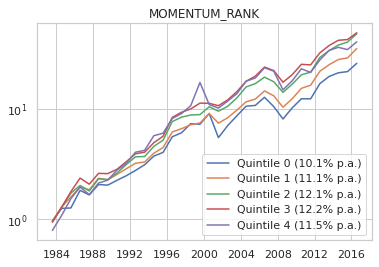

In [20]:
# performance by bucket

col = "MOMENTUM_RANK"
STARTINDEX = 20

def perf_by_bucket(df, col, rank, perfcol="ANNRET"):
    perf = df.loc[df[col]==rank][["DATETIME", col, perfcol]] \
        .groupby("DATETIME") \
        .mean() \
        .reset_index()
    return perf

reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : [],
              'Sharpe': []}

for i in range(num_quantiles):
    tempdf = perf_by_bucket(datanew, col, i).set_index("DATETIME")
    tempdf = tempdf.iloc[STARTINDEX:]
    tempdf["RET1P"] = 1 + (tempdf["ANNRET"])
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    # tempdf.reset_index(inplace=True) # so indexes line up with RF
    tempdf["RF"] = RF["ANNRET"]

    lastval = tempdf["CUMPERF"].iloc[-1]
    nyears = tempdf.shape[0]
    annret = (lastval ** (1/nyears)-1) * 100
    vol = tempdf["ANNRET"].std() * 100
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe["ANNRET"], tempdf_sharpe["RF"]))

    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

plt.title(col)
plt.legend();

pd.DataFrame(reportdict)

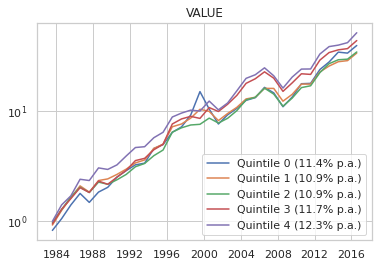

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,11.386147,20.445654,0.367344
1,Quintile 1,10.868248,14.955773,0.472700
2,Quintile 2,10.942928,14.340034,0.496392
3,Quintile 3,11.724478,15.937060,0.495681
4,Quintile 4,12.263106,16.227853,0.521181


In [21]:
def perf_bucket_by_col(data, col, nbuckets=5, startindex=STARTINDEX):

    col_rank = col + "_RANK"

    dflist = []
    for d in uniquedates:
        tempdf = data[data["DATETIME"]==d].copy() # to avoid bucketing on a slice
        dflist.append(bucket_df_by_col(tempdf, col))
    datanew= pd.concat(dflist)

    reportdict = {'Label': [],
                  'Annualized return' : [],
                  'Annualized volatility' : [],
                  'Sharpe': []}
   
    for i in range(nbuckets):
        
        tempdf = perf_by_bucket(datanew, col_rank, i, perfcol="ANNRET").set_index("DATETIME")
        tempdf = tempdf.iloc[startindex:]
        tempdf["RET1P"] = 1 + (tempdf["ANNRET"])
        tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
        tempdf["RF"] = RF["ANNRET"]

        lastval = list(tempdf["CUMPERF"])[-1]
        nyears = tempdf.shape[0]
        annret = (lastval**(1/nyears)-1)*100
        vol = tempdf["ANNRET"].std() * 100

        plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

        reportdict['Label'].append("Quintile %d " % (i))
        reportdict['Annualized return'].append(annret)
        reportdict['Annualized volatility'].append(vol)
        tempdf_sharpe = tempdf.dropna()
        reportdict['Sharpe'].append(sharpe(tempdf_sharpe["ANNRET"], tempdf_sharpe["RF"]))
    
    plt.legend();
    plt.title(col)
    plt.show()

    return pd.DataFrame(reportdict)

col = "VALUE"
perf_bucket_by_col(data, col)


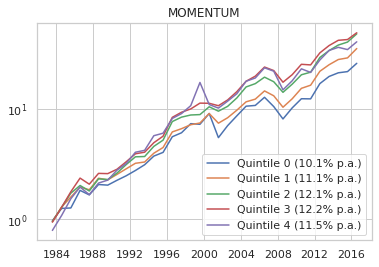

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,10.061785,17.725794,0.350972
1,Quintile 1,11.067686,13.967650,0.519232
2,Quintile 2,12.073409,14.693374,0.561463
3,Quintile 3,12.150349,15.072848,0.553771
4,Quintile 4,11.526403,21.290734,0.359909


In [22]:
perf_bucket_by_col(data, "MOMENTUM")


In [23]:
data = data[['DATETIME', 'GVKEY', 'IND_CODE', 'VALUE', 'MOMENTUM', 'ANNRET',]]

col="VALUE"
# compute normalized value (p/b) by year
data[col + "_NORMALIZED"] = data[["DATETIME", col]] \
    .groupby("DATETIME") \
    .transform(lambda x: (x - x.mean()) / x.std())

col="MOMENTUM"
data[col + "_NORMALIZED"] = data[["DATETIME", col]] \
    .groupby("DATETIME") \
    .transform(lambda x: (x - x.mean()) / x.std())

data

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET,VALUE_NORMALIZED,MOMENTUM_NORMALIZED
0,1963-07-31,1010,25,0.955148,0.698340,0.737034,1.030887,1.588102
1,1963-07-31,1040,6,0.482778,-0.038981,0.152709,-0.363193,-1.567443
2,1963-07-31,1043,41,0.270512,0.006636,-0.087393,-0.989642,-1.372217
3,1963-07-31,1045,40,0.953273,0.498409,0.873546,1.025355,0.732450
4,1963-07-31,1075,31,0.470039,0.200627,0.241477,-0.400789,-0.541981
...,...,...,...,...,...,...,...,...
44736,2016-07-31,264385,12,0.231850,0.147531,0.057716,-0.589352,0.578204
44737,2016-07-31,264708,42,0.535106,-0.028411,0.103621,0.136851,-0.205313
44738,2016-07-31,294524,41,0.273231,-0.184219,0.245865,-0.490258,-0.899166
44739,2016-07-31,295786,21,0.527065,-0.223707,0.632910,0.117596,-1.075017


In [24]:
data["COMBINED"] = data["VALUE_NORMALIZED"] + data["MOMENTUM_NORMALIZED"] 
data


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET,VALUE_NORMALIZED,MOMENTUM_NORMALIZED,COMBINED
0,1963-07-31,1010,25,0.955148,0.698340,0.737034,1.030887,1.588102,2.618989
1,1963-07-31,1040,6,0.482778,-0.038981,0.152709,-0.363193,-1.567443,-1.930637
2,1963-07-31,1043,41,0.270512,0.006636,-0.087393,-0.989642,-1.372217,-2.361859
3,1963-07-31,1045,40,0.953273,0.498409,0.873546,1.025355,0.732450,1.757805
4,1963-07-31,1075,31,0.470039,0.200627,0.241477,-0.400789,-0.541981,-0.942770
...,...,...,...,...,...,...,...,...,...
44736,2016-07-31,264385,12,0.231850,0.147531,0.057716,-0.589352,0.578204,-0.011148
44737,2016-07-31,264708,42,0.535106,-0.028411,0.103621,0.136851,-0.205313,-0.068462
44738,2016-07-31,294524,41,0.273231,-0.184219,0.245865,-0.490258,-0.899166,-1.389423
44739,2016-07-31,295786,21,0.527065,-0.223707,0.632910,0.117596,-1.075017,-0.957421


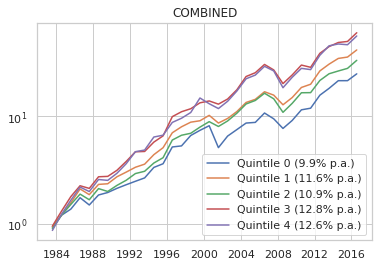

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,9.913929,16.103573,0.377658
1,Quintile 1,11.579407,13.639668,0.569340
2,Quintile 2,10.852405,14.686123,0.478467
3,Quintile 3,12.793136,15.969980,0.563964
4,Quintile 4,12.563606,17.860229,0.489446


In [25]:
col = "COMBINED"
perf_bucket_by_col(data, col)


In [26]:
# dummy variable for financials, enable model to treat them differently, e.g. p/b
data['FINANCIAL'] = 0
data.loc[data["IND_CODE"]==44,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==45,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==46,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==47,"FINANCIAL"] = 1
data.head()

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,ANNRET,VALUE_NORMALIZED,MOMENTUM_NORMALIZED,COMBINED,FINANCIAL
0,1963-07-31,1010,25,0.955148,0.698340,0.737034,1.030887,1.588102,2.618989,0
1,1963-07-31,1040,6,0.482778,-0.038981,0.152709,-0.363193,-1.567443,-1.930637,0
2,1963-07-31,1043,41,0.270512,0.006636,-0.087393,-0.989642,-1.372217,-2.361859,0
3,1963-07-31,1045,40,0.953273,0.498409,0.873546,1.025355,0.732450,1.757805,0
4,1963-07-31,1075,31,0.470039,0.200627,0.241477,-0.400789,-0.541981,-0.942770,0


In [27]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=RANDOMSTATE)


In [28]:
predictors = ['VALUE_NORMALIZED', 'MOMENTUM_NORMALIZED', 'FINANCIAL']
response = 'ANNRET'


In [29]:
elasticnetcv = make_pipeline(RobustScaler(),
                             ElasticNetCV(max_iter=100000, 
                                          l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                          alphas=np.logspace(-4, -2, 9),
                                          cv=kfolds,
                                          n_jobs=-1,
                                          verbose=1,
                                         ))
#train and get hyperparams
elasticnetcv.fit(data[predictors], data[response])
l1_ratio = elasticnetcv._final_estimator.l1_ratio_
alpha = elasticnetcv._final_estimator.alpha_
print('l1_ratio', l1_ratio)
print('alpha', alpha)

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNet(alpha=alpha,
                                      l1_ratio=l1_ratio,
                                      max_iter=10000)
                          )

scores = -cross_val_score(elasticnet, data[predictors], data[response],
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)

print("CV RMSE %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
.............................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
..........................................................................................................................................................................................................................................................................................................................

l1_ratio 0.01
alpha 0.01


..[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.4s finished


CV RMSE 0.3879 (STD 0.0076)


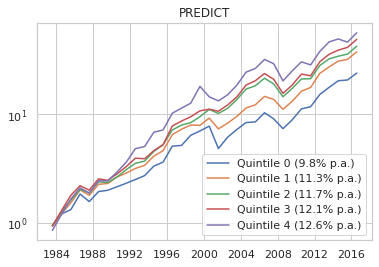

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,9.808093,16.379011,0.364084
1,Quintile 1,11.272301,13.962613,0.533711
2,Quintile 2,11.667276,13.763740,0.571828
3,Quintile 3,12.145663,15.763912,0.528758
4,Quintile 4,12.607436,19.348084,0.454136


In [30]:
elasticnet.fit(data[predictors], data[response])
elasticnet.predict(data[predictors])
data['PREDICT'] = elasticnet.predict(data[predictors])
col = "PREDICT"
perf_bucket_by_col(data, col)

# could do a table
# value alone
# momentum alone
# value momentum combined, simple sum
# value momentum combined, elasticnet model with dummy for financials

# raw ann return
# sharpe
# spread best/worst quintile

# on raw perf and wide consistent spread between quintiles, elasticnet model maybe looks a little better,
# but not on sharpe



..................................

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,10.142029,16.325265,0.386315
1,Quintile 1,11.841720,14.296621,0.561511
2,Quintile 2,12.001580,13.980050,0.585664
3,Quintile 3,11.981236,15.842806,0.516350
4,Quintile 4,11.458108,19.150195,0.397960


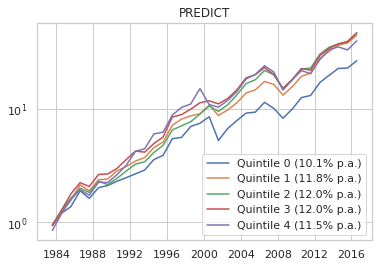

In [31]:
trainindexes = uniquedates[:-10]
predindexes = uniquedates[-10:]
INITIAL_TRAIN_YEARS = 20
response="ANNRET"

def elastic_model(config):
    
    return make_pipeline(RobustScaler(),
                         ElasticNetCV(max_iter=100000, 
                                      l1_ratio=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                      alphas=np.logspace(-4, -2, 9),
                                      cv=kfolds,
                                      n_jobs=-1,
                                      verbose=0,
                                     ))

def run_model(config, model_func, data=data, trainindexes=trainindexes, predindexes=predindexes):
    
    # clean up configs to match ray.tune, Hyperopt, Optuna calling conventions
    # search wants to pass in floats but xgb wants ints
    # tempconfig['max_leaves'] = int(tempconfig['max_leaves'])
    
    traindata = data.loc[data["DATETIME"].isin(trainindexes)]
    preddata = data.loc[data["DATETIME"].isin(predindexes)].copy()
    
    model = model_func(config)
    model.fit(traindata[predictors], traindata[response])
    
    preddata["PREDICT"] = model.predict(preddata[predictors])
    # preddata["PREDICT"] += np.random.uniform(0,0.000001, len(preddata))
    preddata["PREDRANK"] = preddata.groupby(['DATETIME'])['PREDICT'] \
        .transform(lambda x: pd.qcut(x, num_quantiles, labels=False))

    portdata = None
    annrets = []
    for q in range(num_quantiles):
        tmpdf = preddata.loc[preddata["PREDRANK"]==q][["DATETIME", "PREDRANK", "ANNRET"]] \
                .groupby("DATETIME") \
                .mean() \
                .reset_index() \
                .set_index("DATETIME")
        
        if portdata is None:
            portdata = tmpdf
            
        portdata["ANNRET" + str(q)] = tmpdf["ANNRET"]
        portdata["RET1P" + str(q)] = 1 + portdata["ANNRET" + str(q)]
        portdata["CUMPERF" + str(q)] = portdata["RET1P" + str(q)].cumprod()
        annrets.append("ANNRET" + str(q))
            
    maxq = str(num_quantiles-1)
    portdata["RF"] = RF["ANNRET"]
    lastval = portdata.iloc[-1]["CUMPERF" + maxq]
    annret = lastval**(1/len(portdata))-1
    annvol = portdata["ANNRET" + maxq].std()
    sharpe_rat = sharpe(portdata["ANNRET" + maxq], portdata["RF"])
    
    retdict = {"annret": annret, "vol": annvol, "sharpe": sharpe_rat, "portdata": portdata[annrets]}
        
    return retdict


def backtest_viz(tempdf):

    reportdict = {'Label': [],
                  'Annualized return' : [],
                  'Annualized volatility' : [],
                  'Sharpe': []}

    for i in range(num_quantiles):
        ANNRET_I = "ANNRET" + str(i)
        tempdf["RET1P"] = 1 + (tempdf[ANNRET_I])
        tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
        # tempdf.reset_index(inplace=True) # so indexes line up with RF
        tempdf["RF"] = RF["ANNRET"]

        lastval = tempdf["CUMPERF"].iloc[-1]
        nyears = tempdf.shape[0]
        annret = (lastval ** (1/nyears)-1) * 100
        vol = tempdf[ANNRET_I].std() * 100

        reportdict['Label'].append("Quintile %d " % (i))
        reportdict['Annualized return'].append(annret)
        reportdict['Annualized volatility'].append(vol)
        tempdf_sharpe = tempdf.dropna()
        reportdict['Sharpe'].append(sharpe(tempdf_sharpe[ANNRET_I], tempdf_sharpe["RF"]))

        plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

    plt.title(col)
    plt.legend();

    return pd.DataFrame(reportdict)

def dodot(c = '.'):
    sys.stdout.write(c)
    sys.stdout.flush()
        
def my_backtest(config, model_func, initial_train_years=INITIAL_TRAIN_YEARS):
    
    results = []
    nyears = len(uniquedates)

    portdict = {"ANNRET" + str(i): [] for i in range(num_quantiles)}    

    for i in range(initial_train_years, nyears):
        trainindexes = uniquedates[:i]
        # print("-- train", trainindexes)
        predindexes = uniquedates[i:i+1]
        # print(trainindexes[-1], predindexes)
        # print("--  pred", predindexes)
        result = run_model(config, model_func, data, trainindexes, predindexes)
        results.append(result['annret'])
        for i in range(num_quantiles):
            k = "ANNRET" + str(i)
            portdict[k].append(result['portdata'].iloc[-1][k])
        dodot()

    tempdf = pd.DataFrame({"DATETIME": uniquedates[initial_train_years:],
                           "ANNRET" : results})
    tempdf.set_index("DATETIME", inplace=True)
    tempdf["RF"] = RF["ANNRET"]
    for k in portdict.keys():
        tempdf[k] = portdict[k]

    return {"annret": (math.prod([1 + x for x in results]) ** (1/len(results)) -1) * 100,
                "vol": tempdf["ANNRET"].std(),
                "sharpe": sharpe(tempdf["ANNRET"], tempdf["RF"]),
                'port': tempdf           
               }    
        

backtest_results = my_backtest({}, elastic_model)
backtest_viz(backtest_results['port'])


In [32]:
trainindexes = uniquedates[:-10]
predindexes = uniquedates[-10:]

def xgb_model(config):
    
    return XGBRegressor(
        objective='reg:squarederror',
        n_jobs=1,
        random_state=RANDOMSTATE,
        booster='gbtree',
        #tree_method='gpu_hist',
        **config,
    )
    
    
def run_model(config, model_func, data, trainindexes, predindexes, grps=None):
    
    # clean up configs to match ray.tune, Hyperopt, Optuna calling conventions
    # search wants to pass in floats but xgb wants ints
    # tempconfig['max_leaves'] = int(tempconfig['max_leaves'])
    tempconfig = config.copy()
    if tempconfig.get('n_estimators'): tempconfig['n_estimators'] = int(tempconfig['n_estimators'])   
    # hyperopt needs left to start at 0 but we want to start at 2    
    if tempconfig.get('max_depth'): tempconfig['max_depth'] = int(tempconfig['max_depth']) + 2
    # some problem with loguniform (0.001, 0.1)        
    if tempconfig.get('learning_rate'): tempconfig['learning_rate'] = 10 ** tempconfig['learning_rate']
    if tempconfig.get('num_leaves'):tempconfig['num_leaves'] = int(tempconfig['num_leaves'])       # pass float eg loguniform distribution, use int    
    
    traindata = data.loc[data["DATETIME"].isin(trainindexes)]
    preddata = data.loc[data["DATETIME"].isin(predindexes)].copy()
    
    model = model_func(tempconfig)
    if grps:
        model.fit(traindata[predictors], traindata[response], group=grps)
    else:
        model.fit(traindata[predictors], traindata[response])
    
    preddata["PREDICT"] = model.predict(preddata[predictors])
    # preddata["PREDICT"] += np.random.uniform(0,0.000001, len(preddata))
    preddata["PREDRANK"] = preddata.groupby(['DATETIME'])['PREDICT'] \
        .transform(lambda x: pd.qcut(x, num_quantiles, labels=False))

    portdata = None
    annrets = []
    for q in range(num_quantiles):
        tmpdf = preddata.loc[preddata["PREDRANK"]==q][["DATETIME", "PREDRANK", "ANNRET"]] \
                .groupby("DATETIME") \
                .mean() \
                .reset_index() \
                .set_index("DATETIME")
        
        if portdata is None:
            portdata = tmpdf
            
        portdata["ANNRET" + str(q)] = tmpdf["ANNRET"]
        portdata["RET1P" + str(q)] = 1 + portdata["ANNRET" + str(q)]
        portdata["CUMPERF" + str(q)] = portdata["RET1P" + str(q)].cumprod()
        annrets.append("ANNRET" + str(q))
            
    maxq = str(num_quantiles-1)
    portdata["RF"] = RF["ANNRET"]
    lastval = portdata.iloc[-1]["CUMPERF" + maxq]
    annret = lastval**(1/len(portdata))-1
    annvol = portdata["ANNRET" + maxq].std()
    sharpe_rat = sharpe(portdata["ANNRET" + maxq], portdata["RF"])
    
    retdict = {"annret": annret, "vol": annvol, "sharpe": sharpe_rat, "portdata": portdata[annrets]}
        
    return retdict


config = {'n_estimators': 101.42562879793905, 
          'max_depth': 9, 
          'subsample': 0.33, 
          'colsample_bytree': 0.28, 
          'colsample_bylevel': 0.32, 
          'learning_rate': -1.0}

def do_run_xgb(config, data, trainindexes, predindexes, grps=None):
    return run_model(config, xgb_model, data, trainindexes, predindexes, grps=None)

do_run_xgb(config, data, trainindexes, predindexes)



{'annret': 0.07687892490450099,
 'vol': 0.20281708099017326,
 'sharpe': 0.3539861576410907,
 'portdata':              ANNRET0   ANNRET1   ANNRET2   ANNRET3   ANNRET4
 DATETIME                                                    
 2007-07-31 -0.040749 -0.103157 -0.081965 -0.148938 -0.128711
 2008-07-31 -0.260698 -0.217193 -0.217411 -0.215693 -0.267681
 2009-07-31  0.218584  0.184191  0.161548  0.207441  0.245843
 2010-07-31  0.287272  0.249939  0.216132  0.179552  0.265671
 2011-07-31  0.012461  0.038977  0.022843 -0.005547 -0.033440
 2012-07-31  0.287206  0.304577  0.330423  0.347687  0.387367
 2013-07-31  0.161723  0.165303  0.182862  0.162756  0.175415
 2014-07-31  0.111396  0.089094  0.076770  0.109173  0.113841
 2015-07-31  0.014249  0.038002  0.023928  0.040090 -0.022152
 2016-07-31  0.143962  0.161360  0.169453  0.232716  0.214272}

..................................

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,11.146098,15.254093,0.480627
1,Quintile 1,11.632756,14.355773,0.544458
2,Quintile 2,11.127531,14.398062,0.508553
3,Quintile 3,11.769564,15.630878,0.508861
4,Quintile 4,12.335587,16.965170,0.502007


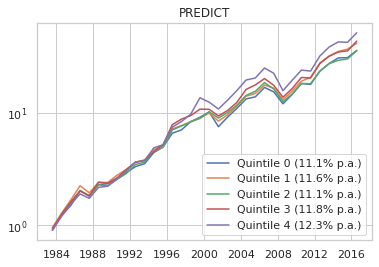

In [33]:
# walk forward 

def dodot(c = '.'):
    sys.stdout.write(c)
    sys.stdout.flush()
        
def run_backtest(config, run_model_func, data, trainindexes, predindexes,
                 initial_train_years=INITIAL_TRAIN_YEARS, grps=None, dots=True):
    
    global uniquedates
    global RF
    
    results = []
    nyears = len(uniquedates)

    portdict = {"ANNRET" + str(i): [] for i in range(num_quantiles)}    

    for i in range(initial_train_years, nyears):
        trainindexes = uniquedates[:i]
        train_grps = grps[:i] if grps else None
        # print("-- train", trainindexes)
        predindexes = uniquedates[i:i+1]
        # print(trainindexes[-1], predindexes)
        # print("--  pred", predindexes)
        result = run_model_func(config, data, trainindexes, predindexes, grps=train_grps)
        results.append(result['annret'])
        for i in range(num_quantiles):
            k = "ANNRET" + str(i)
            portdict[k].append(result['portdata'].iloc[-1][k])
        if dots: dodot()

    tempdf = pd.DataFrame({"DATETIME": uniquedates[initial_train_years:],
                           "ANNRET" : results})
    tempdf.set_index("DATETIME", inplace=True)
    tempdf["RF"] = RF["ANNRET"]
    for k in portdict.keys():
        tempdf[k] = portdict[k]

    return {"annret": (math.prod([1 + x for x in results]) ** (1/len(results)) -1) * 100,
            "vol": tempdf["ANNRET"].std(),
            "sharpe": sharpe(tempdf["ANNRET"], tempdf["RF"]),
            'port': tempdf           
           }

config = {'n_estimators': 489.411066700849, 'max_depth': 3, 'subsample': 0.37, 'colsample_bytree': 0.48, 'colsample_bylevel': 0.68, 'learning_rate': -1.0}        
backtest_results = run_backtest(config, do_run_xgb, data, trainindexes, predindexes)
backtest_viz(backtest_results['port'])


In [34]:
# find best params with ray tune and hyperopt
start_time = datetime.now()

NUM_SAMPLES=128

xgb_tune_kwargs = {
    "n_estimators": tune.loguniform(10, 10000),
    "max_depth": tune.randint(0, 12),
    # max_leaves doesn't seem to have any impact on XGBoost but num_leaves does help LGBM, oddly.
    # 'max_leaves': tune.loguniform(1, 1000),    
    "subsample": tune.quniform(0.2, 0.8, 0.01),
    "colsample_bytree": tune.quniform(0.05, 0.85, 0.01),
    "colsample_bylevel": tune.quniform(0.05, 0.85, 0.01),    
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5),
}

def my_backtest(config):
    return run_backtest(config, do_run_xgb, data, trainindexes, predindexes, dots=False)

print("%-20s %s" % ("Start Time", start_time))

algo = HyperOptSearch(random_state_seed=RANDOMSTATE)
# to limit number of cores, uncomment and set max_concurrent 
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

ray.shutdown()
ray.init()

analysis = tune.run(my_backtest,
                    num_samples=NUM_SAMPLES,
                    config=xgb_tune_kwargs,                    
                    name="hyperopt_xgb",
                    metric="annret",
                    mode="max",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
                    raise_on_failed_trial=False,
#                     loggers=DEFAULT_LOGGERS + (WandbLogger, ),
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))



Trial name,# failures,error file
my_backtest_a42331e2,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_a42331e2_13_colsample_bylevel=0.68,colsample_bytree=0.06,learning_rate=-1.5,max_depth=0,n_estimators=5893.5,subsample=_2021-01-02_11-43-43/error.txt"
my_backtest_b11a3588,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_b11a3588_15_colsample_bylevel=0.71,colsample_bytree=0.48,learning_rate=-1.0,max_depth=0,n_estimators=60.84,subsample=0_2021-01-02_11-43-52/error.txt"
my_backtest_b2797146,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_b2797146_16_colsample_bylevel=0.5,colsample_bytree=0.09,learning_rate=-2.0,max_depth=0,n_estimators=409.23,subsample=0_2021-01-02_11-43-54/error.txt"
my_backtest_a5e3b29d,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_a5e3b29d_27_colsample_bylevel=0.33,colsample_bytree=0.24,learning_rate=-1.5,max_depth=0,n_estimators=41.811,subsample=_2021-01-02_11-50-51/error.txt"
my_backtest_ad217698,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_ad217698_29_colsample_bylevel=0.39,colsample_bytree=0.46,learning_rate=-1.5,max_depth=0,n_estimators=29.276,subsample=_2021-01-02_11-51-02/error.txt"
my_backtest_b258186b,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_b258186b_31_colsample_bylevel=0.63,colsample_bytree=0.47,learning_rate=-1.0,max_depth=0,n_estimators=32.145,subsample=_2021-01-02_11-51-10/error.txt"
my_backtest_b7349a03,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_b7349a03_33_colsample_bylevel=0.59,colsample_bytree=0.44,learning_rate=-1.0,max_depth=0,n_estimators=32.264,subsample=_2021-01-02_11-51-12/error.txt"
my_backtest_b9b443ae,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_b9b443ae_35_colsample_bylevel=0.73,colsample_bytree=0.19,learning_rate=-1.0,max_depth=0,n_estimators=40.039,subsample=_2021-01-02_11-51-30/error.txt"
my_backtest_c463b816,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_c463b816_37_colsample_bylevel=0.71,colsample_bytree=0.43,learning_rate=-1.0,max_depth=0,n_estimators=28.929,subsample=_2021-01-02_11-51-49/error.txt"
my_backtest_cfa082c2,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_cfa082c2_39_colsample_bylevel=0.66,colsample_bytree=0.43,learning_rate=-1.0,max_depth=0,n_estimators=38.14,subsample=0_2021-01-02_11-52-06/error.txt"


2021-01-02 12:31:25,155	ERROR tune.py:444 -- Trials did not complete: [my_backtest_a42331e2, my_backtest_b11a3588, my_backtest_b2797146, my_backtest_a5e3b29d, my_backtest_ad217698, my_backtest_b258186b, my_backtest_b7349a03, my_backtest_b9b443ae, my_backtest_c463b816, my_backtest_cfa082c2, my_backtest_d872f133, my_backtest_e06d10f3, my_backtest_e9808dd6, my_backtest_ea7150c2, my_backtest_ea7150c3, my_backtest_ecb92b8e, my_backtest_0386936a, my_backtest_33572a46, my_backtest_3442bede, my_backtest_3442bedf, my_backtest_360dc600, my_backtest_360dc601, my_backtest_37c80d34, my_backtest_37c80d35, my_backtest_39b89474, my_backtest_39b89475, my_backtest_3b7f2a52, my_backtest_3b7f2a53, my_backtest_3d6cf722, my_backtest_3d6cf723, my_backtest_3f486540, my_backtest_415f8265, my_backtest_415f8266, my_backtest_4434caee, my_backtest_45246f4a, my_backtest_46259b30, my_backtest_46259b31, my_backtest_4d6d031a, my_backtest_4f055c72, my_backtest_57ec23b6, my_backtest_5e7f4992, my_backtest_61b4b8e1, my_ba

Start Time           2021-01-02 11:43:27.401130
End Time             2021-01-02 12:31:25.336561
0:47:57


In [35]:
uniquedates2 = data[["DATETIME"]].copy()
uniquedates2['INDEX'] = data.index
uniquedates2 = uniquedates2.groupby("DATETIME").first().reset_index()
grptemp = list(uniquedates2["INDEX"])
grptemp.append(len(data))
grps = [grptemp[i] - grptemp[i-1] for i in range(1, len(grptemp))]
print(len(data), sum(grps))
grps



44741 44741


[428,
 464,
 503,
 533,
 535,
 566,
 610,
 589,
 658,
 673,
 672,
 871,
 851,
 806,
 818,
 765,
 771,
 761,
 780,
 761,
 779,
 768,
 780,
 822,
 763,
 795,
 758,
 805,
 819,
 857,
 935,
 967,
 1015,
 1077,
 1077,
 1153,
 1113,
 1052,
 1010,
 1014,
 949,
 979,
 909,
 931,
 910,
 897,
 875,
 891,
 908,
 942,
 913,
 972,
 973,
 918]

In [36]:
len(grps), len(uniquedates)


(54, 54)

In [37]:
trainindexes = uniquedates[:-10]
predindexes = uniquedates[-10:]
grpstest = grps[:-10]

def xgb_rank_model(config):
    
    return XGBRanker(
        # objective='rank:pairwise',
        n_jobs=1,
        random_state=RANDOMSTATE,
        booster='gbtree', 
        #tree_method='gpu_hist',
        **config,
    )

 
def do_run_xgb_rank(config, data, trainindexes, predindexes, grps=grpstest):
    return run_model(config, xgb_rank_model, data, trainindexes, predindexes, grps=grps)

do_run_xgb_rank(config, data, trainindexes, predindexes)


{'annret': 0.07537673899762676,
 'vol': 0.19304078256245574,
 'sharpe': 0.3633850773479443,
 'portdata':              ANNRET0   ANNRET1   ANNRET2   ANNRET3   ANNRET4
 DATETIME                                                    
 2007-07-31 -0.059604 -0.099489 -0.055275 -0.109867 -0.180334
 2008-07-31 -0.232647 -0.225999 -0.260626 -0.231968 -0.227672
 2009-07-31  0.237872  0.200254  0.167273  0.192924  0.219388
 2010-07-31  0.267877  0.278123  0.256784  0.238123  0.152475
 2011-07-31  0.007204  0.008405  0.038778 -0.014511 -0.004740
 2012-07-31  0.277536  0.300799  0.322169  0.356482  0.402268
 2013-07-31  0.188194  0.153381  0.186200  0.158582  0.161443
 2014-07-31  0.143276  0.105191  0.122468  0.054963  0.073875
 2015-07-31  0.023305 -0.012850  0.022510 -0.001083  0.061921
 2016-07-31  0.126496  0.179347  0.171112  0.187069  0.257718}

..................................

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,11.273140,16.859148,0.442024
1,Quintile 1,12.043006,14.858658,0.553691
2,Quintile 2,9.940395,15.927352,0.382760
3,Quintile 3,11.458630,14.845641,0.514241
4,Quintile 4,13.099623,16.651479,0.559109


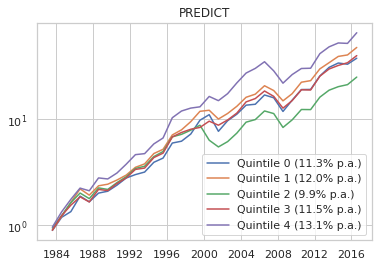

In [38]:
config = {'n_estimators': 18.91629259514074, 'max_depth': 3, 'subsample': 0.39, 'colsample_bytree': 0.31, 'colsample_bylevel': 0.76, 'learning_rate': -1.0}

backtest_results = run_backtest(config, do_run_xgb_rank, data, trainindexes, predindexes, grps=grps)
backtest_viz(backtest_results['port'])


In [39]:
# find best params with ray tune and hyperopt
start_time = datetime.now()

NUM_SAMPLES=128

xgb_tune_kwargs = {
    "n_estimators": tune.loguniform(10, 10000),
    "max_depth": tune.randint(0, 12),
    # max_leaves doesn't seem to have any impact on XGBoost but num_leaves does help LGBM, oddly.
    # 'max_leaves': tune.loguniform(1, 1000),    
    "subsample": tune.quniform(0.2, 0.8, 0.01),
    "colsample_bytree": tune.quniform(0.05, 0.85, 0.01),
    "colsample_bylevel": tune.quniform(0.05, 0.85, 0.01),    
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5),
}

def my_backtest(config):
    return run_backtest(config, do_run_xgb_rank, data, trainindexes, predindexes, grps=grps, dots=False)    

print("%-20s %s" % ("Start Time", start_time))

algo = HyperOptSearch(random_state_seed=RANDOMSTATE)
# to limit number of cores, uncomment and set max_concurrent 
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

ray.shutdown()
ray.init()

analysis = tune.run(my_backtest,
                    num_samples=NUM_SAMPLES,
                    config=xgb_tune_kwargs,                    
                    name="hyperopt_xgb",
                    metric="annret",
                    mode="max",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
                    raise_on_failed_trial=False,
#                     loggers=DEFAULT_LOGGERS + (WandbLogger, ),
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))


Trial name,# failures,error file
my_backtest_701d1294,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_701d1294_13_colsample_bylevel=0.68,colsample_bytree=0.06,learning_rate=-1.5,max_depth=0,n_estimators=5893.5,subsample=_2021-01-02_12-32-27/error.txt"
my_backtest_82e571e4,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_82e571e4_15_colsample_bylevel=0.71,colsample_bytree=0.48,learning_rate=-1.0,max_depth=0,n_estimators=60.84,subsample=0_2021-01-02_12-32-46/error.txt"
my_backtest_87041a64,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_87041a64_16_colsample_bylevel=0.5,colsample_bytree=0.09,learning_rate=-2.0,max_depth=0,n_estimators=409.23,subsample=0_2021-01-02_12-32-47/error.txt"
my_backtest_c0ff28a2,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_c0ff28a2_25_colsample_bylevel=0.63,colsample_bytree=0.65,learning_rate=-1.0,max_depth=2,n_estimators=10.594,subsample=_2021-01-02_12-42-18/error.txt"
my_backtest_dbd72e7d,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_dbd72e7d_27_colsample_bylevel=0.63,colsample_bytree=0.65,learning_rate=-1.0,max_depth=2,n_estimators=12.408,subsample=_2021-01-02_12-42-21/error.txt"
my_backtest_ddd90402,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_ddd90402_28_colsample_bylevel=0.71,colsample_bytree=0.6,learning_rate=-1.5,max_depth=0,n_estimators=35.232,subsample=0_2021-01-02_12-42-24/error.txt"
my_backtest_e5f3c5f0,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_e5f3c5f0_31_colsample_bylevel=0.46,colsample_bytree=0.44,learning_rate=-1.0,max_depth=0,n_estimators=34.79,subsample=0_2021-01-02_12-43-00/error.txt"
my_backtest_fcb43ad6,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_fcb43ad6_35_colsample_bylevel=0.54,colsample_bytree=0.28,learning_rate=-1.0,max_depth=0,n_estimators=108.94,subsample=_2021-01-02_12-43-25/error.txt"
my_backtest_09d1c08a,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_09d1c08a_39_colsample_bylevel=0.53,colsample_bytree=0.29,learning_rate=-1.0,max_depth=0,n_estimators=31.074,subsample=_2021-01-02_12-43-51/error.txt"
my_backtest_138e6416,1,"/home/ubuntu/ray_results/hyperopt_xgb/my_backtest_138e6416_40_colsample_bylevel=0.47,colsample_bytree=0.56,learning_rate=-3.0,max_depth=8,n_estimators=10.781,subsample=_2021-01-02_12-43-53/error.txt"


2021-01-02 13:35:19,582	ERROR tune.py:444 -- Trials did not complete: [my_backtest_701d1294, my_backtest_82e571e4, my_backtest_87041a64, my_backtest_c0ff28a2, my_backtest_dbd72e7d, my_backtest_ddd90402, my_backtest_e5f3c5f0, my_backtest_fcb43ad6, my_backtest_09d1c08a, my_backtest_138e6416, my_backtest_14754ade, my_backtest_1756b9c2, my_backtest_19166aaa, my_backtest_19166aab, my_backtest_1b13f70b, my_backtest_1c97c7a0, my_backtest_1d705390, my_backtest_1d705391, my_backtest_1eff204c, my_backtest_1fdda588, my_backtest_1fdda589, my_backtest_21d1932c, my_backtest_22b0c7d6, my_backtest_22b0c7d7, my_backtest_248ba603, my_backtest_2655871e, my_backtest_2655871f, my_backtest_28347194, my_backtest_29306ac6, my_backtest_2ae523fc, my_backtest_2bc3079e, my_backtest_2bc3079f, my_backtest_2da306cc, my_backtest_2e8b92f2, my_backtest_2e8b92f3, my_backtest_304f3e22, my_backtest_31534138, my_backtest_323465fa, my_backtest_323465fb, my_backtest_33f35068, my_backtest_363e67c2, my_backtest_38a81116, my_ba

Start Time           2021-01-02 12:32:03.593379
End Time             2021-01-02 13:35:19.759729
1:03:16


In [39]:
data["IDEALRANK"] = data.groupby(['DATETIME'])['ANNRET'] \
    .transform(lambda x: pd.qcut(x, num_quantiles, labels=False))
data["IDEALRANK"] = data["IDEALRANK"].astype(int)
response = "IDEALRANK"

In [40]:
data[response]

0        4
1        2
2        0
3        4
4        3
        ..
44736    1
44737    1
44738    3
44739    4
44740    2
Name: IDEALRANK, Length: 44741, dtype: int64

In [41]:
trainindexes = uniquedates[:-10]
predindexes = uniquedates[-10:]
grpstest = grps[:-10]

def lgbm_rank_model(config):
    
    return LGBMRanker(**config)

 
def do_run_lgbm_rank(config, data, trainindexes, predindexes, grps=grpstest):
    return run_model(config, lgbm_rank_model, data, trainindexes, predindexes, grps=grps)

config = {'n_estimators': 2372.7083996503093, 
          'max_depth': 9, 
          'num_leaves': 8.659097168326424, 
          'bagging_fraction': 0.66, 
          'feature_fraction': 0.12, 
          'learning_rate': -2.0}

do_run_lgbm_rank(config, data, trainindexes, predindexes)


{'annret': 0.06526609926604787,
 'vol': 0.19986868593450471,
 'sharpe': 0.3016421103495297,
 'portdata':              ANNRET0   ANNRET1   ANNRET2   ANNRET3   ANNRET4
 DATETIME                                                    
 2007-07-31 -0.081931 -0.105492 -0.092892 -0.118698 -0.104506
 2008-07-31 -0.220947 -0.240535 -0.189424 -0.235313 -0.292648
 2009-07-31  0.199325  0.191109  0.194931  0.205096  0.227145
 2010-07-31  0.239490  0.249233  0.240170  0.228633  0.241310
 2011-07-31  0.058909  0.031105  0.010075  0.002935 -0.067726
 2012-07-31  0.325796  0.310929  0.317575  0.339085  0.363795
 2013-07-31  0.173591  0.148954  0.164429  0.172960  0.188090
 2014-07-31  0.115622  0.083431  0.093208  0.102232  0.105801
 2015-07-31  0.042201  0.055281  0.023615 -0.003102 -0.024011
 2016-07-31  0.153573  0.175860  0.210447  0.185586  0.196309}

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
[LightGBM] [Warning] bagging_fraction is set=0.24, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24
[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
[LightGBM] [Warning] bagging_fraction is set=0.24, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24
[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
[LightGBM] [Warning] bagging_fraction is set=0.24, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24
[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
[LightGBM] [Warning] bagging_fraction is set=0.24, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24
[LightGBM] [Warning]

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,11.728627,14.669581,0.539470
1,Quintile 1,11.626365,14.727880,0.529817
2,Quintile 2,10.980212,14.852306,0.482617
3,Quintile 3,10.388421,15.644942,0.419163
4,Quintile 4,13.369701,15.853875,0.604476


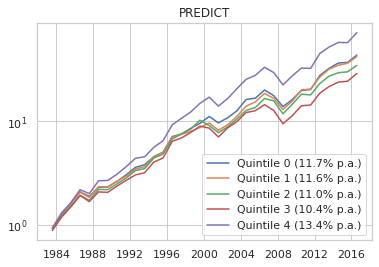

In [42]:
config = {'n_estimators': 29.735693070775344, 'max_depth': 8, 'num_leaves': 516.4288202430997, 'bagging_fraction': 0.24, 'feature_fraction': 0.59, 'learning_rate': -2.5}

backtest_results = run_backtest(config, do_run_lgbm_rank, data, trainindexes, predindexes, grps=grps, dots=False)
backtest_viz(backtest_results['port'])


In [58]:
# find best params with ray tune and hyperopt
start_time = datetime.now()

NUM_SAMPLES=128

lgbm_tune_kwargs = {
    "n_estimators": tune.loguniform(10, 10000),
    "max_depth": tune.randint(0, 12),
    'num_leaves': tune.loguniform(2, 1000),               # xgb max_leaves
    "bagging_fraction": tune.quniform(0.2, 0.8, 0.01),    # xgb subsample
    "feature_fraction": tune.quniform(0.05, 0.85, 0.01),   # xgb colsample_bytree
    "learning_rate": tune.quniform(-3.0, -1.0, 0.5),
}

def my_backtest(config):
    return run_backtest(config, do_run_lgbm_rank, data, trainindexes, predindexes, grps=grps, dots=False)    

print("%-20s %s" % ("Start Time", start_time))

algo = HyperOptSearch(random_state_seed=RANDOMSTATE)
# to limit number of cores, uncomment and set max_concurrent 
# algo = ConcurrencyLimiter(algo, max_concurrent=10)
scheduler = AsyncHyperBandScheduler()

ray.shutdown()
ray.init()

analysis = tune.run(my_backtest,
                    num_samples=NUM_SAMPLES,
                    config=lgbm_tune_kwargs,                    
                    name="hyperopt_lgbm",
                    metric="annret",
                    mode="max",
                    search_alg=algo,
                    scheduler=scheduler,
                    verbose=1,
                    raise_on_failed_trial=False,
#                     loggers=DEFAULT_LOGGERS + (WandbLogger, ),
                   )

end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))

Trial name,# failures,error file
my_backtest_5c304b7c,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_5c304b7c_1_bagging_fraction=0.59,feature_fraction=0.8,learning_rate=-1.5,max_depth=1,n_estimators=1099.3,num_leaves=2._2021-01-02_14-26-06/error.txt"
my_backtest_5c304b7d,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_5c304b7d_2_bagging_fraction=0.36,feature_fraction=0.12,learning_rate=-3.0,max_depth=8,n_estimators=4500.9,num_leaves=2_2021-01-02_14-26-06/error.txt"
my_backtest_5c304b83,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_5c304b83_8_bagging_fraction=0.44,feature_fraction=0.34,learning_rate=-2.0,max_depth=2,n_estimators=199.87,num_leaves=6_2021-01-02_14-26-07/error.txt"
my_backtest_bd1d91be,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_bd1d91be_28_bagging_fraction=0.46,feature_fraction=0.67,learning_rate=-2.5,max_depth=3,n_estimators=29.926,num_leaves=_2021-01-02_14-36-36/error.txt"
my_backtest_d8058cac,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_d8058cac_30_bagging_fraction=0.46,feature_fraction=0.63,learning_rate=-2.5,max_depth=8,n_estimators=23.425,num_leaves=_2021-01-02_14-37-44/error.txt"
my_backtest_0e29236a,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_0e29236a_36_bagging_fraction=0.64,feature_fraction=0.66,learning_rate=-3.0,max_depth=8,n_estimators=39.278,num_leaves=_2021-01-02_14-46-30/error.txt"
my_backtest_36c19028,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_36c19028_38_bagging_fraction=0.62,feature_fraction=0.13,learning_rate=-3.0,max_depth=8,n_estimators=48.113,num_leaves=_2021-01-02_14-47-50/error.txt"
my_backtest_66736508,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_66736508_40_bagging_fraction=0.62,feature_fraction=0.42,learning_rate=-3.0,max_depth=8,n_estimators=34.388,num_leaves=_2021-01-02_14-51-29/error.txt"
my_backtest_e7c07471,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_e7c07471_42_bagging_fraction=0.65,feature_fraction=0.15,learning_rate=-3.0,max_depth=8,n_estimators=30.806,num_leaves=_2021-01-02_14-52-20/error.txt"
my_backtest_07fc6bd6,1,"/home/ubuntu/ray_results/hyperopt_lgbm/my_backtest_07fc6bd6_44_bagging_fraction=0.65,feature_fraction=0.78,learning_rate=-3.0,max_depth=9,n_estimators=21.311,num_leaves=_2021-01-02_14-52-41/error.txt"


2021-01-02 15:40:05,774	ERROR tune.py:444 -- Trials did not complete: [my_backtest_5c304b7c, my_backtest_5c304b7d, my_backtest_5c304b83, my_backtest_bd1d91be, my_backtest_d8058cac, my_backtest_0e29236a, my_backtest_36c19028, my_backtest_66736508, my_backtest_e7c07471, my_backtest_07fc6bd6, my_backtest_131738e8, my_backtest_142bb8a8, my_backtest_170bcc7a, my_backtest_170bcc7b, my_backtest_189ab452, my_backtest_189ab453, my_backtest_1b94ec04, my_backtest_1b94ec05, my_backtest_1d1e5bc8, my_backtest_1f6c4a70, my_backtest_28e8a710, my_backtest_423bb3d8, my_backtest_43387244, my_backtest_443a0c16, my_backtest_4c2c5e10, my_backtest_4d35d2a0, my_backtest_54785984, my_backtest_557e34f2, my_backtest_5cb84596, my_backtest_62f26554, my_backtest_6f8417ea, my_backtest_751c03ac, my_backtest_769b4472, my_backtest_7c47dc5a, my_backtest_7f0a17a0, my_backtest_831dc8a0, my_backtest_90f7fa0f, my_backtest_b9cb14b6, my_backtest_f310dc24, my_backtest_1f746309, my_backtest_4b34f426, my_backtest_64290bf2, my_ba

Start Time           2021-01-02 14:26:02.275374
End Time             2021-01-02 15:40:05.998156
1:14:03


In [47]:
len(uniquedates)

54